# Learning low-rank Gaussian embeddings from scratch for a toy graph

This notebook shows you how to use gGO to learn node Gaussian embeddings. To this aim, a synthetic graph is generated to be used as the input for learning node representations. Finally, the learned embeddings are visually inspected to demonstrate the benefits of using low-rank Gaussian distributions.

## Preamble

In [ ]:
#@title Install gGO
url = "git+https://github.com/blindcosmos/ggo.git"

# to avoid dependency conflicts on colab
!pip uninstall -y imgaug > /dev/null 
!pip uninstall -y albumentations > /dev/null

# now install it
!pip install -U {url} > /dev/null

  Running command git clone -q https://github.com/blindcosmos/ggo.git /tmp/pip-req-build-sjvzqkmg


In [ ]:
#@title Import libraries
import os
import numpy as np
import string

import networkx as nx

import scipy.sparse
from scipy.stats import multivariate_normal as mvnormal

# plot
from matplotlib import rc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [ ]:
#@title Load utilities
def plot_normals(normals, axs, MAXVALX=10, MAXVALY=10, labels=None, title=None):
  """
  Plot 2D normals using their confidence ellipses.
  
  Arguments
  ---------
    normals: [scipy.stats.multivariate_normal]
      A list of 2D normal distributions.
  """

  # ellipsis scales for representing confidence intervals
  cis = [
         5.991,  # scipy.stats.chi2.ppf(.68, df=2)
  ]

  # create the new map
  #cmap = plt.cm.get_cmap('tab10') #plt.cm.get_cmap('tab10', len(normals))
  cmap = plt.cm.get_cmap('cividis', len(normals))
    
  lws = [.6]
  # loop over input gaussians
  for i, normal in enumerate(normals):
    # draw confidence ellipses
    #
    # eigen decomposition of covariance matrix
    # eigenvalues and eigenvectors, where v[:,i] is the eigenvector for w[i]
    w, v = np.linalg.eig(normal.cov) 
    # calculate angle of the ellipsis
    rangle = np.arctan(v[1,1] / (v[0,1]+0.000001)) # radiant, and small constant for avoiding zero division
    dangle = rangle*(180/np.pi) # radiant to degree
    
    # draw ellipsis for three stds
    for k, ci in enumerate(cis):
        # lengths of ellipsis axes
        lengths = 2*np.sqrt(w*ci)
        e = Ellipse(xy=normal.mean, 
                    height=lengths[0], 
                    width=lengths[1], 
                    angle=dangle,
                    zorder=1)

        axs.add_artist(e)
        e.set_facecolor(cmap(i))
        e.set_edgecolor('black')#cmap(i))
        e.set_linewidth(.4)#lws[k])
        e.set_alpha(0.90) #1-np.clip(k/len(cis) + 0.1, 0, 1))
    
        if labels is not None and k == 0:
            mean.set_label(labels[i])
    
  axs.tick_params(axis='both', labelsize=5)

  axs.set_xlim([-MAXVALX,MAXVALX])
  axs.set_ylim([-MAXVALY,MAXVALY])
    
  if title is not None:
    axs.set_title(title, fontsize=5)

  if labels is not None:
    axs.legend(loc='lower left', prop={'size': 5})

def calculate_entropies(mean, diag, covm=None):
    if covm is None:
      # Diagonal Gaussian
      entropies = [
          mvnormal(mean[i], np.diag(diag[i])).entropy()
          for i in range(mean.shape[0])
      ]
    else:
      # Low-rank Gaussian
      entropies = [
          mvnormal(mean[i], (covm[i,:] @ covm[i,:].T) + np.diag(diag[i])).entropy()
          for i in range(mean.shape[0])
      ]
    
    return np.array(entropies)

## Input graph

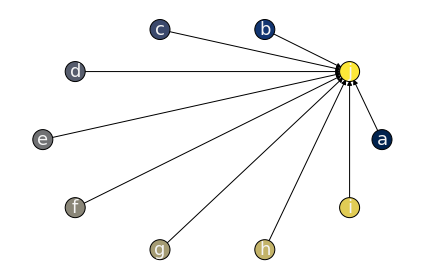

In [ ]:
#@title Create a synthetic graph
# generate graph
ndim = 10
adj = np.zeros((ndim, ndim), dtype=np.float32)
#adj[0,:] = 1.
#np.fill_diagonal(adj, 1.)
adj[:,-1] = 1.
adj = scipy.sparse.csr_matrix(adj)
mat_fin = 'sp.npz'
scipy.sparse.save_npz(mat_fin, adj)
#adj

# draw graph
G = nx.DiGraph()


node_labels = list(string.ascii_lowercase)[:ndim]
cmap = plt.cm.get_cmap('cividis', ndim)
node2col = {n:cmap(i) for i,n in enumerate(node_labels)}
for i in range(ndim - 1):
  G.add_edge(node_labels[i], 
             node_labels[ndim-1])

pos = nx.circular_layout(G)

options = {
    "edgecolors": "black",
    "node_color": [node2col[n] for n in G.nodes()], 
    "node_size": 400
}

nx.draw_networkx_nodes(G, 
                       pos, 
                       **options)
nx.draw_networkx_labels(G, 
                        pos, 
                        font_size=18, 
                        font_color="whitesmoke")
nx.draw_networkx_edges(G, 
                       pos,
                       edge_color='k', 
                       arrows=True)

plt.tight_layout()
plt.axis("off")

plt.show()

## Learn Gaussian embeddings

Given an input graph with $n$ nodes, gGO learns  for each node $i$ an embedding with the form $\mathcal{N}(\mu_i, \Sigma_i)$, where $\mu_i$ is the mean in $\mathbb{R}^{n}$ and $\Sigma_i$ is the covariance matrix in $\mathbb{R}^{n\times n}$.

In the diagonal approximation, $\Sigma_i=D_i$, where $D_i\in\mathbb{R}^{n\times n}$ is a diagonal matrix. In contrast, in the low-rank approximation, $\Sigma_i=D_i+P_iP_i^T$, where $P_i\in\mathbb{R}^{n\times r}$ and $r$ is the rank.

In [ ]:
%%capture
#@title Learn diagonal embeddings
emb_dim     = 2           # embedding dimension
sigma_type0 = 0           # -1 spherical, 0 diagonal, >1 low-rank
use_cuda    = 0           # >0 use cuda
prefix_out0 = 'diagonal_' # prefix for output files

num_epochs  = 8000        # @param {type:"slider", min:1, max:10000, step:1}
batch_size  = 128         # @param {type:"slider", min:1, max:1024, step:1}

# build diagonal Gaussian embeddings
!gGO {mat_fin} {emb_dim} {sigma_type0} {num_epochs} {batch_size} {use_cuda} {prefix_out0} > /dev/null

In [ ]:
%%capture
#@title Learn low-rank embeddings
# second set of arguments
sigma_type1 = 1           
prefix_out1 = 'lowrank1_'

num_epochs  = 8000        # @param {type:"slider", min:1, max:10000, step:1}
batch_size  = 128         # @param {type:"slider", min:1, max:1024, step:1}

# train low-rank Gaussian embeddings
!gGO {mat_fin} {emb_dim} {sigma_type1} {num_epochs} {batch_size} {use_cuda} {prefix_out1} > /dev/null

## Visualize the learned embeddings

In [ ]:
#@title Read the learned Gaussian embeddings

# diagonal embeddings 
mean_dg = np.load('diagonal_mean.npy')
diag_dg = np.load('diagonal_diag.npy')

# low-rank embeddings
mean_lr = np.load('lowrank1_mean.npy')
diag_lr = np.load('lowrank1_diag.npy')
covm_lr = np.load('lowrank1_covm.npy')

In [ ]:
#@title Define densities from embeddings and calculate their entropies

# 1. define Gaussian densities using the embeddings
# diagonal embeddings
gauss_dg = []
for m,d in zip(mean_dg, diag_dg):
    cov = np.diag(d)
    gauss_dg.append(mvnormal(m, cov))

# low-rank embeddings
gauss_lr = []
for m,c,d in zip(mean_lr, covm_lr, diag_lr):
    cov = np.diag(d) + (c @ c.T)
    gauss_lr.append(mvnormal(m, cov))

# 2. calculate entropies
entropies_dg = calculate_entropies(mean_dg, diag_dg)
entropies_lr = calculate_entropies(mean_lr, diag_lr, covm_lr)

dists = [
    [gauss_dg, entropies_dg], 
    [gauss_lr, entropies_lr],
]

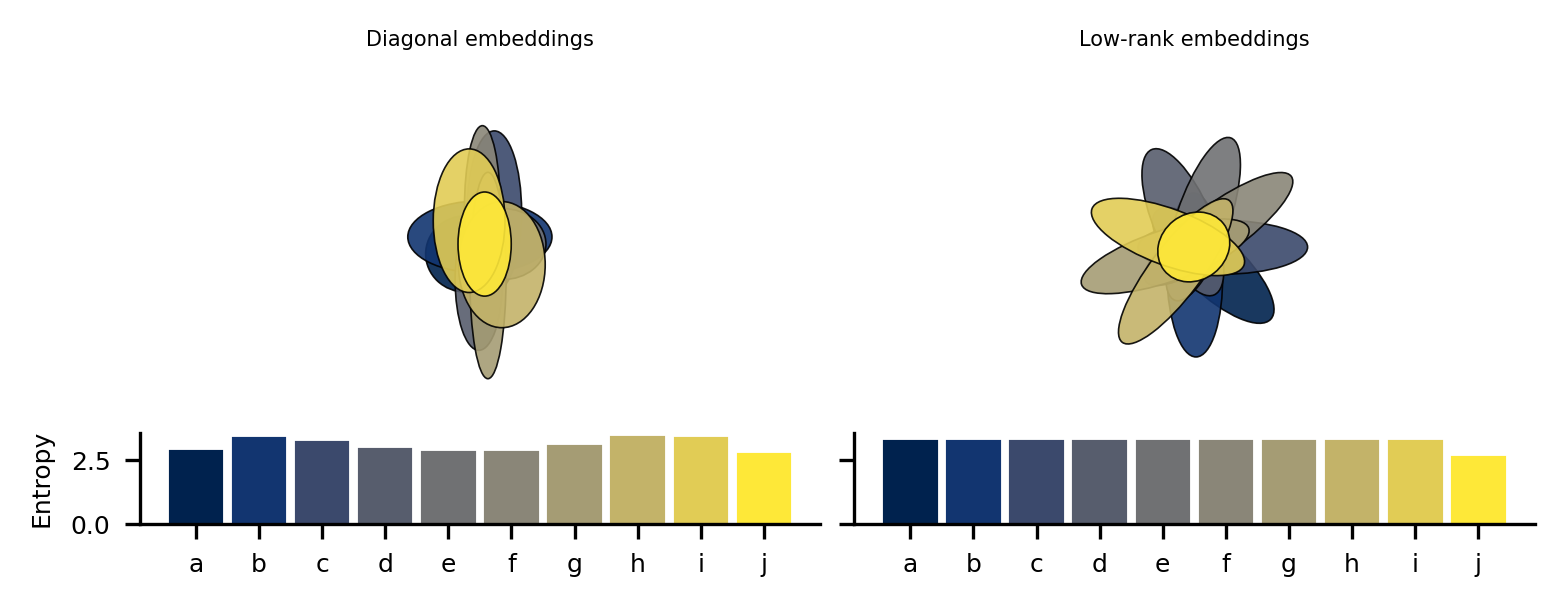

In [ ]:
#@title Plot Gaussian embeddings
#@markdown Note that the low-rank embeddings are able to capture the hierarchy of the graph such that the leaf nodes show homogeneous entropies whereas the root shows the lowest entropy.
titles = ['Diagonal embeddings', 'Low-rank embeddings']
fig, axs = plt.subplots(2, 2, figsize=(6,2), dpi=300, sharey='row', gridspec_kw={'height_ratios':[1.6,.4]})
for j, (g, e) in enumerate(dists):
    #cmap = plt.cm.get_cmap('cividis', len(g))
    
    plot_normals(g, axs[0,j], MAXVALX=11.2, MAXVALY=11.2, title=titles[j])
    axs[0,j].set_aspect('equal')
    
    bars = axs[1,j].bar(np.arange(e.shape[0]), e)
    for i, b in enumerate(bars):
        b.set_color(cmap(i))

    axs[0,j].tick_params(
      axis='both',          
      which='both',      
      bottom=False,      
      top=False,         
      left=False,
      labelleft=False,
      labelbottom=False)
    
    axs[0,j].spines['top'].set_visible(False)
    axs[0,j].spines['right'].set_visible(False)
    axs[0,j].spines['bottom'].set_visible(False)
    axs[0,j].spines['left'].set_visible(False)
    
    axs[1,j].spines['top'].set_visible(False)
    axs[1,j].spines['right'].set_visible(False)

    # node labelings
    axs[1,j].set_xticks(range(len(node_labels)))
    axs[1,j].set_xticklabels(node_labels)

for i in range(2):
  axs[1,i].tick_params(axis='both', 
                       which='both',
                       labelsize=6)

axs[1,0].set_ylabel('Entropy', fontsize=6)
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()